# Análise: Ofertas Relâmpago

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
plt.style.use("seaborn-whitegrid")
palette = sns.color_palette("blend:#fff159,white,#383f78")

In [5]:
df = pd.read_csv("../data/raw/ofertas_relampago.csv",
                 parse_dates=["OFFER_START_DATE", "OFFER_START_DTTM", "OFFER_FINISH_DTTM"])

In [6]:
df.head()

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES


In [7]:
df.tail()

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
48741,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,15,9,16.28,6.0,NaN,none,HOME&DECOR,HOME & INDUSTRY,MLM-CHRISTMAS_LIGHTS
48742,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-DECORATIVE_PAINTINGS
48743,2021-06-19,2021-06-19 07:00:00+00:00,2021-06-19 13:00:03+00:00,lightning_deal,5,3,16.62,2.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS
48744,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:00+00:00,lightning_deal,5,1,38.79,4.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS
48745,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:00+00:00,lightning_deal,15,15,NaN,NaN,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-BED_SHEETS


In [8]:
df["SOLD_AMOUNT"] = df["SOLD_AMOUNT"].fillna(0)
df["SOLD_QUANTITY"] = df["SOLD_QUANTITY"].fillna(0)

---

## Sucesso da operação

**Vamos entender o sucesso/fracasso da operação através da análise do estoque vendido.**

Olhando o gráfico abaixo podemos notar que: 
- Mais de **60%** das campanhas vende apenas **10%** do estoque ou menos, sendo **49.58%** sem nenhuma venda.
- Apenas **5.43%** das campanhas vende entre **90%** e **100%** do estoque, sendo que **4.95%** venderam tudo.
- Mais de **80%** das campanhas vendem menos de **50%** do estoque.
- **2.54%** das campanhas vendeu mais de **100%** do estoque. Potencialmente uma quebra de estoque.

Baseado nesses dados podemos considerar uma campanha boa quando ela atinge uma venda *superior a 10%* do estoque disponibilizado. 
Podemos ainda considerar um sucesso caso venda pelo menos 50% do estoque disponibilizado.

**obs:**
A coluna `REMAINING_STOCK_AFTER_END` não reflete a diferença entre `INVOLVED_STOCK` e `SOLD_QUANTITY` em 7.35% (3583) dos casos. 🤔

In [9]:
# Calculating remaining stock based on qty sold - qty involved
df["STOCK_DIFF"] = df["INVOLVED_STOCK"] - df["SOLD_QUANTITY"]

# Calculating stock divergence between stock diff and REMAINING_STOCK_AFTER_END
df["STOCK_DIVERGENCE"] = df["REMAINING_STOCK_AFTER_END"] - df["STOCK_DIFF"]

df["STOCK_DIVERGENCE"].sort_values()

11227   -108.0
45799    -67.0
16142    -66.0
43921    -54.0
17201    -53.0
         ...  
5796     610.0
32793    618.0
43829    644.0
19952    691.0
5774     752.0
Name: STOCK_DIVERGENCE, Length: 48746, dtype: float64

In [10]:
print(f"""
Campanhas com divergência no estoque: {df[df["STOCK_DIVERGENCE"] != 0].shape[0]} ({round(df[df["STOCK_DIVERGENCE"] != 0].shape[0] / df.shape[0] * 100, 2)}%)
""")


Campanhas com divergência no estoque: 3583 (7.35%)



In [11]:
# Getting perc of sold stock
df["PERC_STOCK_SOLD"] = round(df["SOLD_QUANTITY"] / df["INVOLVED_STOCK"] * 100, 2)
df["PERC_STOCK_SOLD_TRUNC"] = df["PERC_STOCK_SOLD"].apply(lambda x: x if x<=100 else 101)

# Converting it into bins
df["BINNED_PERC_STOCK_SOLD"] = pd.cut(
    df["PERC_STOCK_SOLD_TRUNC"], 
    include_lowest=True,
    bins=[0, 10, 50, 90, 100, 110],
    labels=["10%", "50%", "90%", "100%", "> 100%"], 
    )

In [12]:
print(f"""
Campanhas sem vendas: {df[df["SOLD_QUANTITY"].isna()].shape[0]} ({df[df["SOLD_QUANTITY"].isna()].shape[0] / df.shape[0] * 100:.02f}%)
Campanhas que venderam tudo: {df[df["STOCK_DIFF"] == 0].shape[0]} ({df[df["STOCK_DIFF"] == 0].shape[0] / df.shape[0] * 100:.02f}%)
""")


Campanhas sem vendas: 0 (0.00%)
Campanhas que venderam tudo: 2412 (4.95%)



In [13]:
# Creating a new DF with bins as index, total sold per bin and perc sold per bin
df_stock = df.groupby("BINNED_PERC_STOCK_SOLD")[["BINNED_PERC_STOCK_SOLD"]].count().rename(columns={"BINNED_PERC_STOCK_SOLD": "sold"})
df_stock.index.names = ["bins"]

df_stock["perc_sold"] = round(df_stock["sold"] / df.shape[0] * 100, 2)

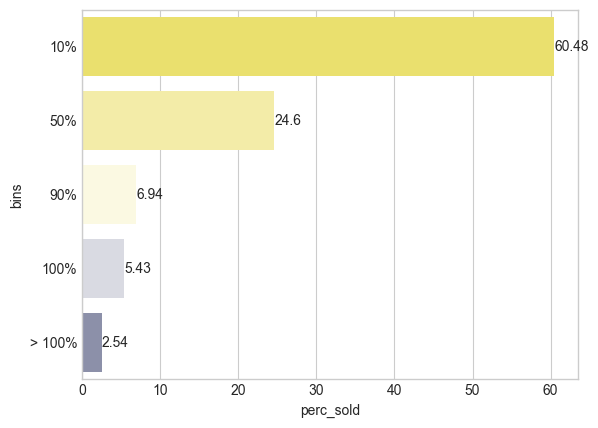

In [14]:
ax = sns.barplot(data=df_stock, x="perc_sold", y=df_stock.index, palette=palette)
ax.bar_label(ax.containers[0])
plt.show()

### Influência do Free-shipping

**O free shipping tem influência no sucesso de uma oferta relâmpago?**

Analisando os gráficos abaixo, o free-shipping sozinho não posssui influência no sucesso da operação. Na verdade observamos um aumento das operações com baixo retorno de venda dos estoques.

In [15]:
# total sold and perc only for free-shipping campaings
df_stock = df_stock.join(
    df[df["SHIPPING_PAYMENT_TYPE"] == "free_shipping"]
    .groupby("BINNED_PERC_STOCK_SOLD")[["BINNED_PERC_STOCK_SOLD"]].count().rename(columns={"BINNED_PERC_STOCK_SOLD": "sold_free_shipping"})
)

df_stock["perc_sold_free_shipping"] = round(df_stock["sold_free_shipping"] / df[df["SHIPPING_PAYMENT_TYPE"] == "free_shipping"].shape[0] * 100, 2)

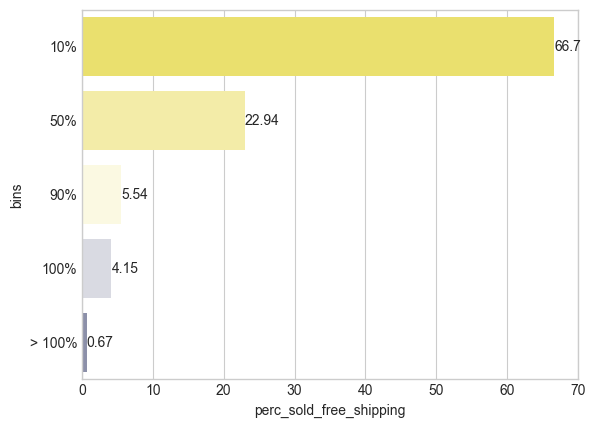

In [16]:
ax = sns.barplot(data=df_stock, x="perc_sold_free_shipping", y=df_stock.index, palette=palette)
ax.bar_label(ax.containers[0])
plt.show()

---

## Duração da oferta

A maioria das campanhas possui duração de **6h**, seguido por **8h**

Ofertas com duração mais curtas - entre **1h** e **5h** - costumam vender uma porção maior do seu estoque disponibilizado (proporcionalmente), porém trazem um resultado financeiro menor, justamente por terem menos itens disponibilizados. Ou seja, quanto maior a duração da campanha, maior é o retorno financeiro da mesma.

Campanhas menores possuem uma representatividade muito baixa, a maioria absoluta tem duração de **6h** ou **8h**, por que? Algum viés no cadstro das campanhas?

Questão para análise futura:
- O horário de atividade da campanha tem influência na sua performance?


In [17]:
df["OFFER_DURATION"] = (df["OFFER_FINISH_DTTM"] - df["OFFER_START_DTTM"]).astype("timedelta64[h]")
df["OFFER_DURATION"] = df["OFFER_DURATION"].apply(lambda x: f"{int(x):02} h" if x<9 else "08+ h")

<AxesSubplot:xlabel='OFFER_DURATION', ylabel='Count'>

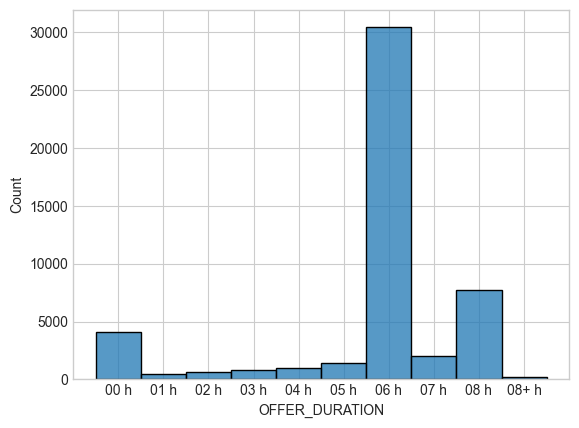

In [31]:
sns.histplot(df["OFFER_DURATION"].sort_values())

<AxesSubplot:xlabel='PERC_STOCK_SOLD_TRUNC', ylabel='OFFER_DURATION'>

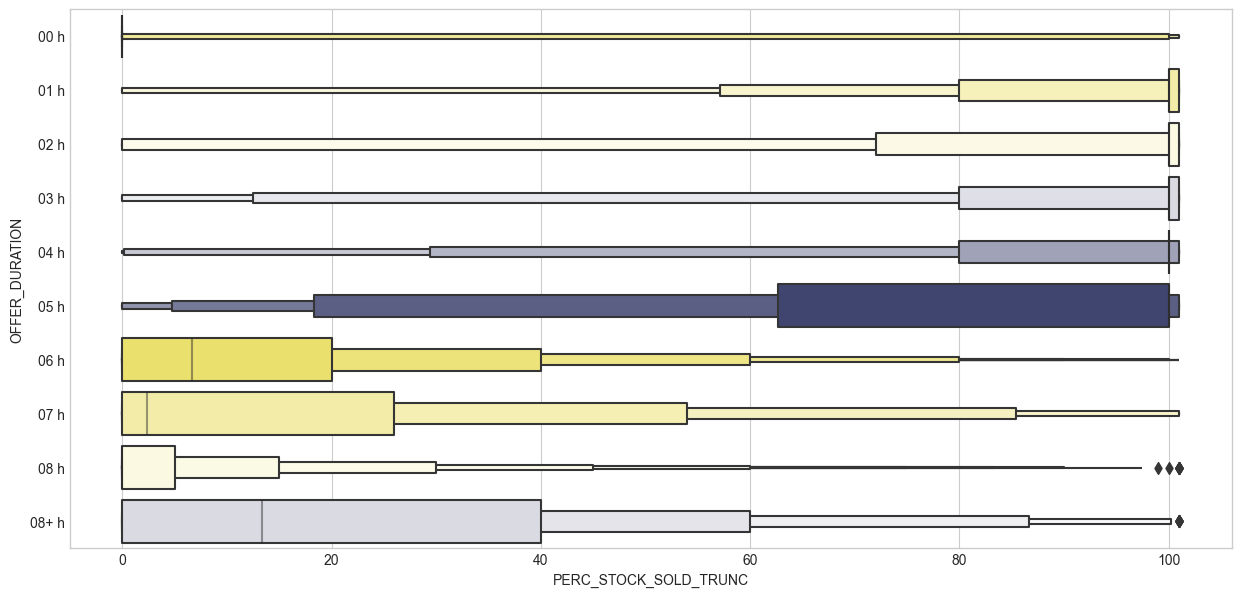

In [19]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxenplot(ax=ax, 
              data=df, 
              x="PERC_STOCK_SOLD_TRUNC", 
              y="OFFER_DURATION", 
              palette=palette,
              order=sorted(list(df["OFFER_DURATION"].unique())))

<AxesSubplot:xlabel='INVOLVED_STOCK', ylabel='OFFER_DURATION'>

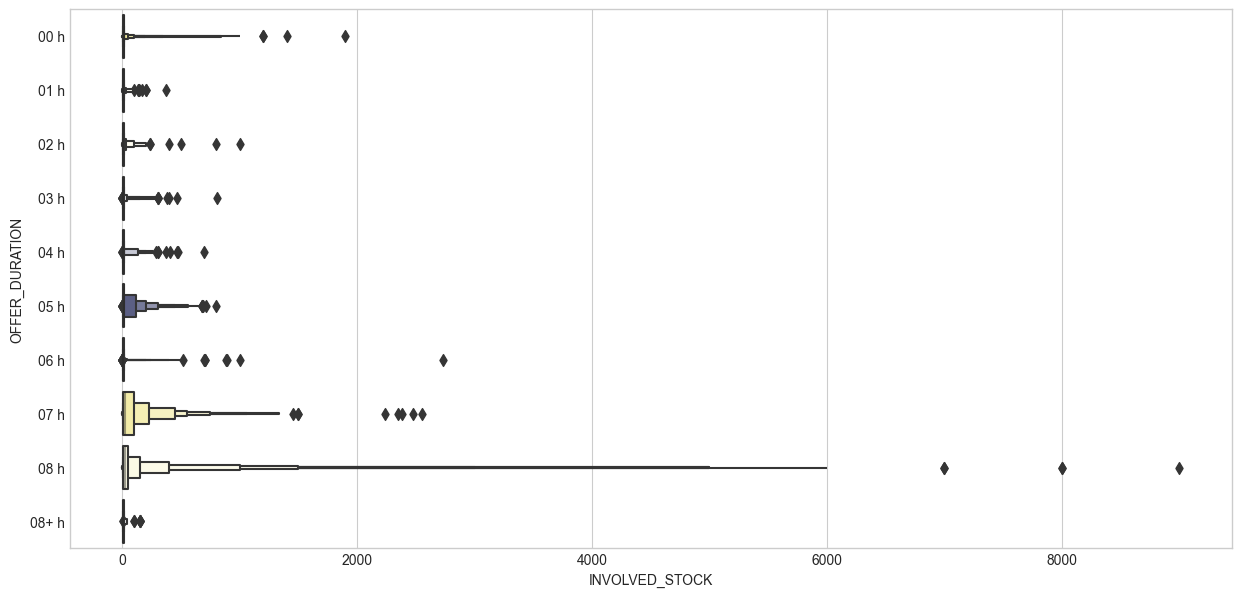

In [20]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxenplot(ax=ax, 
              data=df, 
              x="INVOLVED_STOCK", 
              y="OFFER_DURATION", 
              palette=palette,
              order=sorted(list(df["OFFER_DURATION"].unique())))

<AxesSubplot:xlabel='SOLD_AMOUNT', ylabel='OFFER_DURATION'>

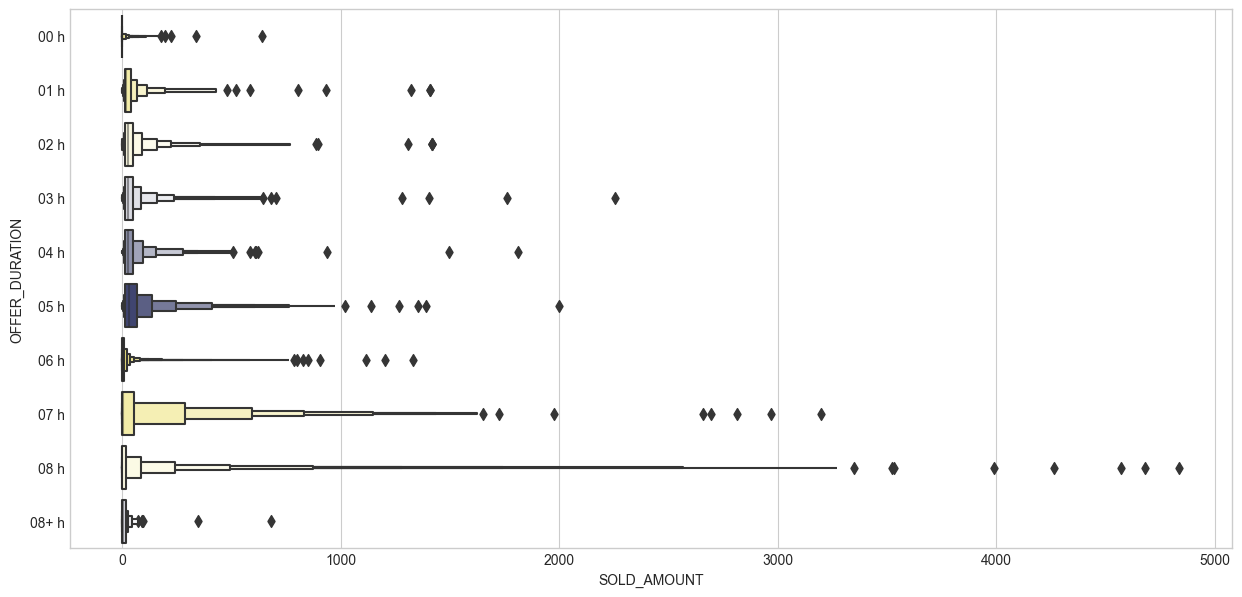

In [29]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxenplot(ax=ax, 
              data=df, 
              x="SOLD_AMOUNT", 
              y="OFFER_DURATION", 
              palette=palette,
              order=sorted(list(df["OFFER_DURATION"].unique())))

---

## Vertical e Domain

É possível identificar uma predominância de campanhas da vertical **APP & SPORTS** seguida por **HOME & INDUSTRY**, porém:
- Quando olhamos para estoque, as verticais **BEAUTY & HEALTH** e **ACC** tem uma performance um pouco melhor (proporcionalmente).
- Quando olhamos para valores, as verticais **BEAUTY & HEALTH** e **CE** tem uma performance um pouco melhor (proporcionalmente), o que é esperado por se tratar de bens com valor mais elevado - especialmente na vertocal **CE**

Olhando isoladamente para os domínios, o que mais se destaca é o **HOME & DECOR**, que empurra a presença de sua vertical (HOME & INDUSTRY) para cima.

/Users/adrianofreitas/prj/meli/.venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


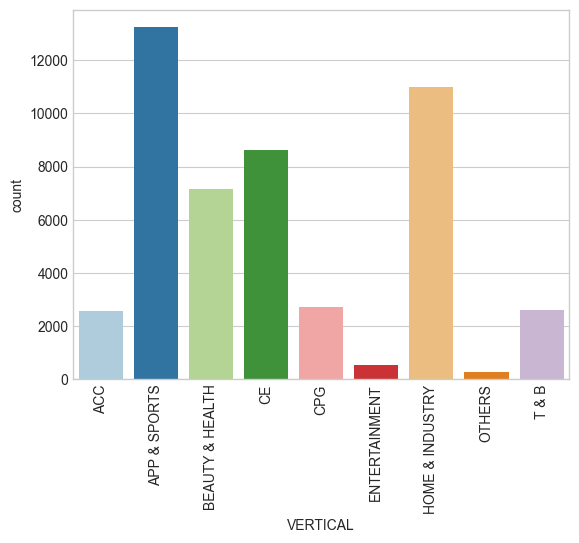

In [21]:
sns.countplot(df["VERTICAL"].sort_values(), palette=sns.color_palette("Paired"))
plt.xticks(rotation=90)
plt.show()

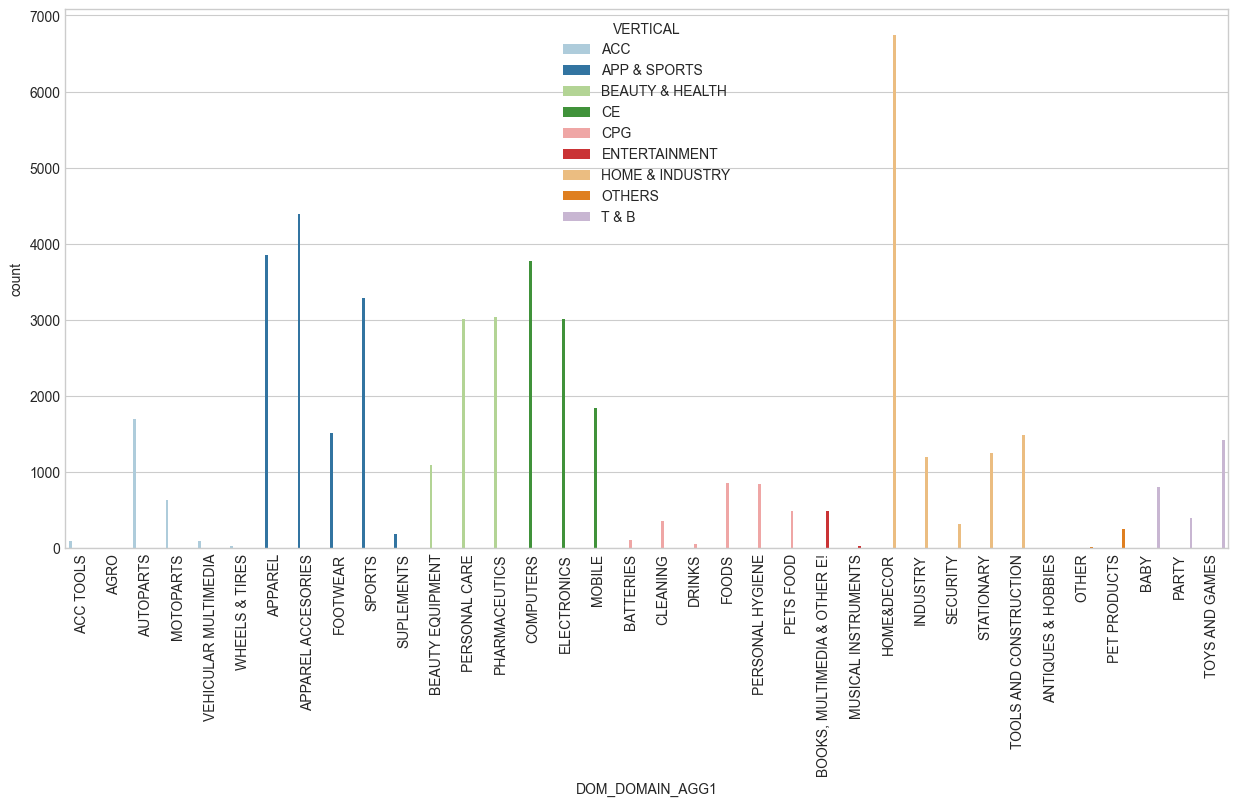

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.countplot(ax=ax, data=df.sort_values(by=["VERTICAL", "DOM_DOMAIN_AGG1"]), x="DOM_DOMAIN_AGG1", hue="VERTICAL", palette=sns.color_palette("Paired"))

plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='PERC_STOCK_SOLD_TRUNC', ylabel='VERTICAL'>

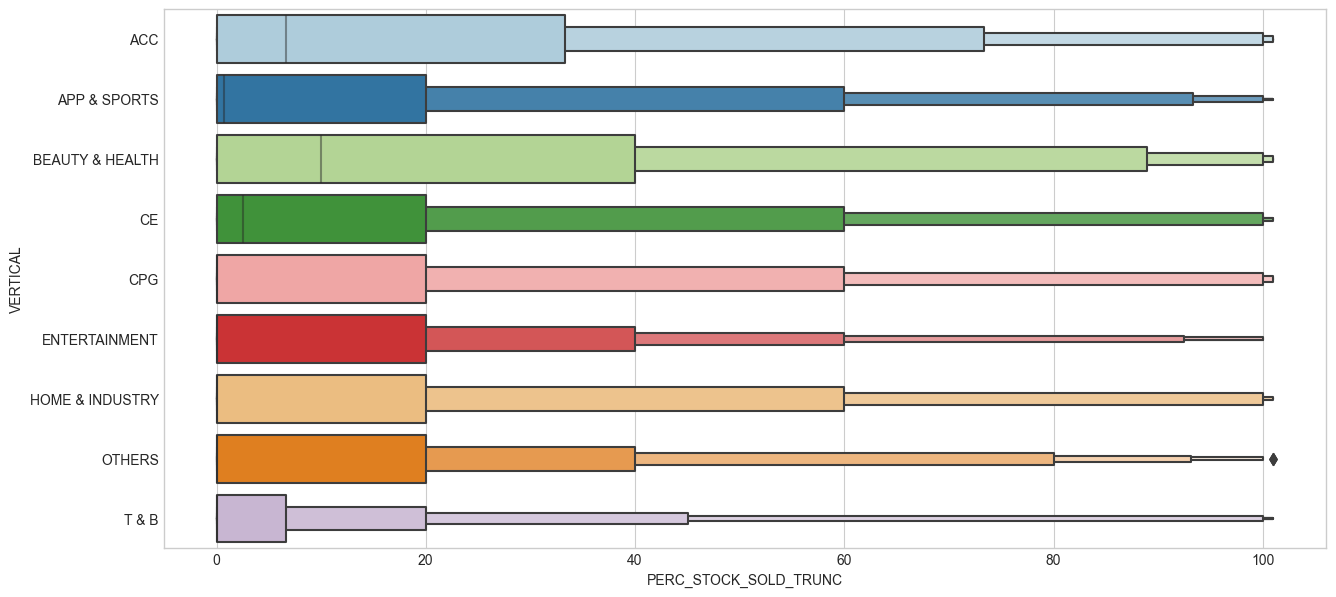

In [28]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxenplot(ax=ax, 
              data=df, 
              x="PERC_STOCK_SOLD_TRUNC", 
              y="VERTICAL", 
              palette=sns.color_palette("Paired"),
              order=sorted(list(df["VERTICAL"].unique())))

<AxesSubplot:xlabel='SOLD_AMOUNT', ylabel='VERTICAL'>

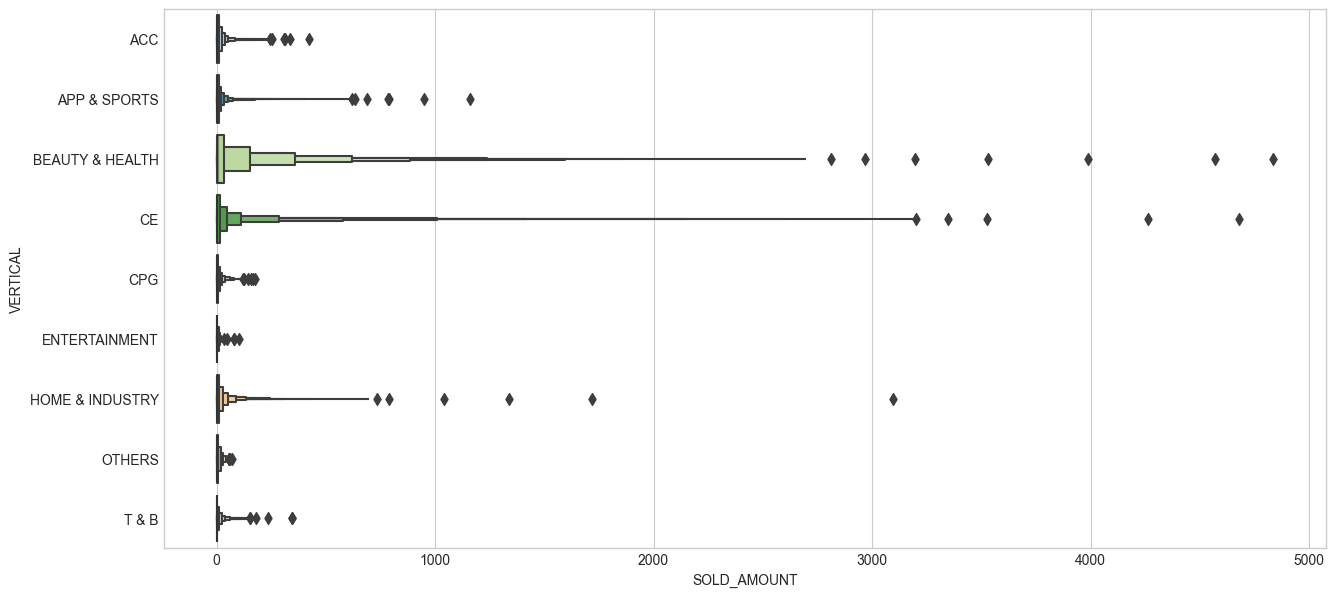

In [27]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxenplot(ax=ax, 
              data=df, 
              x="SOLD_AMOUNT", 
              y="VERTICAL", 
              palette=sns.color_palette("Paired"),
              order=sorted(list(df["VERTICAL"].unique())))